In [1]:
pip install vncorenlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=38a2e3e1f26074c03810c2c1a96ed269918ffeab2c98bd2010cd433d5dfa65ca
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [2]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2024-06-07 18:48:20--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2024-06-07 18:48:22 (248 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2024-06-07 18:48:22--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [3]:
pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00


In [4]:
pip install tensorflow

In [5]:
pip install keras


**Data Loader**

In [6]:
TRAIN = '/content/drive/MyDrive/mid_NLP/train.csv'
DEV = '/content/drive/MyDrive/mid_NLP/dev.csv'
TEST = '/content/drive/MyDrive/mid_NLP/test.csv'

LABEL = '/content/drive/MyDrive/mid_NLP/labels.csv'

import pandas as pd

train = pd.read_csv(TRAIN)
dev = pd.read_csv(DEV)
test = pd.read_csv(TEST)

label = pd.read_csv(LABEL)
job_types = label['job_type'].values

In [7]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import vncorenlp
from vncorenlp import VnCoreNLP

In [29]:
import numpy as np
import re
from pyvi import ViTokenizer

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

def custom_tokenizer(text_data, tokenizer='vncorenlp'):
    # text_data = text_data.lower()
    if tokenizer == 'vncorenlp':
        # return " ".join(vncorenlp.tokenize(str(text_data))[0])
        text = ""
        lst = vncorenlp.tokenize(str(text_data))
        for t in lst:
            text += " ".join(t)
        return text
    if tokenizer == 'none':
        return text_data
    return ViTokenizer.tokenize(str(text_data))

def pre_process(X, y):
    sentences = []

    for t in X:
        t = re.sub(r"[-()\"#/@;:<>{}`+=~|!?,]", "", t)
        sentences.append(custom_tokenizer(t, tokenizer='vncorenlp'))



    return (sentences, y)

In [9]:
data = pd.concat([train, dev], ignore_index=True)

In [27]:
# Chia lại dữ liệu train và val theo tỉ lệ 8:2
X_train, X_val, y_train, y_val = train_test_split(
    data['job_description'],
    data['job'],
    test_size=0.2,
    random_state=42
)

In [28]:
y_train = y_train.apply(eval).tolist()
y_val = y_val.apply(eval).tolist()

In [31]:
# Tiền xử lý dữ liệu
X1, y1 = pre_process(X_train.tolist(), y_train)
X2, y2 = pre_process(X_val.tolist(), y_val)
X3, y3 = pre_process(test['job_description'].tolist(), test['job'].apply(eval).tolist())


In [32]:
# Tách từ cho tất cả các văn bản trong tập dữ liệu
all_texts = X1 + X2 + X3

# Tách từ cho tất cả các văn bản
tokenized_texts = [text.split() for text in all_texts]


In [34]:
tokenized_texts[1]

['Liên_hệ',
 'với',
 'khách_hàng',
 'thị_trường',
 'Trung_Quốc',
 'theo',
 'các',
 'thông_tin',
 'thu_thập',
 'được',
 'và',
 'các',
 'thông_tin',
 'do',
 'Công_ty',
 'cung_cấp',
 'để',
 'giới_thiệu',
 'về',
 'các',
 'công_nghệ',
 'giải_pháp',
 'kỹ_thuật',
 'trong',
 'lĩnh_vực',
 'xử_lý',
 'nước_thải',
 'xử_lý',
 'nước',
 'cấp',
 '.Tổng_hợp',
 'thông_tin',
 'lên',
 'kế_hoạch',
 'tiếp_cận',
 'khách_hàng',
 'tới',
 'TP.',
 'Kinh_doanh',
 'miền',
 'Bắc',
 '.Biên',
 'phiên_dịch',
 'thông_tin',
 'cho',
 'TP.',
 'Kinh_doanh',
 'hoặc',
 'TGĐ',
 'trong',
 'các',
 'buổi',
 'làm_việc',
 'trực_tiếp',
 'với',
 'khách_hàng',
 'Trung_Quốc',
 '.Tiếp_nhận',
 'thông_tin',
 'của',
 'khách_hàng',
 'và',
 'báo_cáo',
 'chính_xác',
 'kịp_thời',
 'tới',
 'TP.',
 'Kinh_doanh',
 'miền',
 'Bắc',
 'để',
 'có',
 'phương_án',
 'đối_ứng',
 'tốt',
 'nhất',
 '.Phối_hợp',
 'với',
 'Phòng',
 'Đấu_thầu',
 '–',
 'Hợp_đồng',
 'để',
 'biên_dịch',
 'các',
 'tài_liệu',
 'được',
 'giao',
 '.Thực_hiện',
 'các',
 'nhiệm_vụ',
 '

In [57]:
# Huấn luyện mô hình Word2Vec
embedding_dim = 100  # Kích thước của embeddings - 100
word2vec_model = Word2Vec(tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Lưu trữ embeddings
word_vectors = word2vec_model.wv

In [58]:
# Chuyển đổi văn bản thành chuỗi số dựa trên từ điển Word2Vec
def text_to_sequence(text, word_vectors):
    return [word_vectors.key_to_index[word] if word in word_vectors else 0 for word in text.split()]

# Chuyển đổi các văn bản trong tập train, dev và test
train_sequences = [text_to_sequence(text, word_vectors) for text in X1]
dev_sequences = [text_to_sequence(text, word_vectors) for text in X2]
test_sequences = [text_to_sequence(text, word_vectors) for text in X3]


In [59]:
# Đệm các chuỗi để tất cả đều có độ dài như nhau
maxlen = 100
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_val = pad_sequences(dev_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)


In [60]:
# Chuyển đổi nhãn sang định dạng nhị phân
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y1)
y_val = mlb.transform(y2)
y_test = mlb.transform(y3)

In [61]:
# Tạo ma trận embeddings
vocab_size = len(word_vectors)
embedding_matrix = np.zeros((vocab_size + 2, embedding_dim))

# Điền ma trận embeddings với các vectors từ Word2Vec
for word, i in word_vectors.key_to_index.items():
    embedding_vector = word_vectors[word]
    if embedding_vector is not None:
        embedding_matrix[i + 2] = embedding_vector

# Thêm embeddings ngẫu nhiên cho các từ đặc biệt UNK và PAD
embedding_matrix[1] = np.random.randn(embedding_dim)  # UNK
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD

In [62]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM, GRU, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [63]:
# Xây dựng mô hình FFNN
model_ffnn = Sequential()
model_ffnn.add(Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_ffnn.add(Flatten())
model_ffnn.add(Dense(256, activation='relu'))
model_ffnn.add(BatchNormalization())
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(BatchNormalization())
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(y_train.shape[1], activation='sigmoid'))

In [64]:
model_ffnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          4494000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               2560256   
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                      

In [65]:
model_ffnn.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [66]:
# Thiết lập EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình
history_ffnn = model_ffnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/20
275/275 [==============================] - 16s 53ms/step - loss: 0.4484 - accuracy: 0.1438 - val_loss: 0.0946 - val_accuracy: 0.2948
Epoch 2/20
275/275 [==============================] - 14s 51ms/step - loss: 0.0951 - accuracy: 0.2714 - val_loss: 0.0675 - val_accuracy: 0.3378
Epoch 3/20
275/275 [==============================] - 14s 49ms/step - loss: 0.0744 - accuracy: 0.3204 - val_loss: 0.0582 - val_accuracy: 0.3433
Epoch 4/20
275/275 [==============================] - 13s 49ms/step - loss: 0.0644 - accuracy: 0.3517 - val_loss: 0.0523 - val_accuracy: 0.3699
Epoch 5/20
275/275 [==============================] - 12s 45ms/step - loss: 0.0578 - accuracy: 0.3814 - val_loss: 0.0485 - val_accuracy: 0.3649
Epoch 6/20
275/275 [==============================] - 13s 49ms/step - loss: 0.0526 - accuracy: 0.4049 - val_loss: 0.0464 - val_accuracy: 0.3430
Epoch 7/20
275/275 [==============================] - 16s 60ms/step - loss: 0.0480 - accuracy: 0.4305 - val_loss: 0.0449 - val_accuracy:

In [67]:
import matplotlib.pyplot as plt

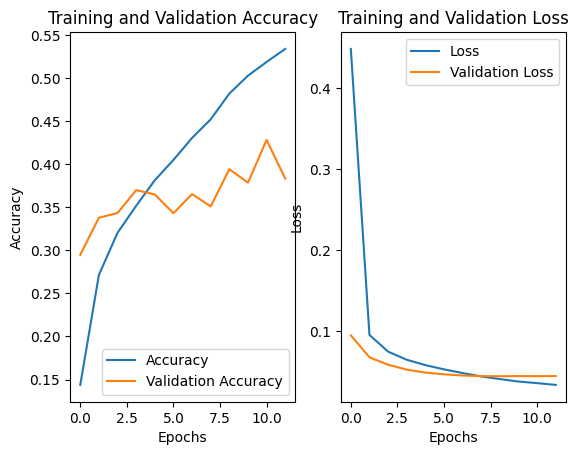

In [68]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history_ffnn.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [69]:
# Đánh giá mô hình FFNN
ffnn_score = model_ffnn.evaluate(X_test, y_test, batch_size=64)
print(f'FFNN Test loss: {ffnn_score[0]}')
print(f'FFNN Test accuracy: {ffnn_score[1]}')

62/62 [==============================] - 1s 12ms/step - loss: 0.0643 - accuracy: 0.3539
FFNN Test loss: 0.06429722905158997
FFNN Test accuracy: 0.3539282977581024


In [70]:
# Dự đoán với mô hình FFNN
ffnn_predictions = model_ffnn.predict(X_test)
# Chuyển đổi dự đoán thành nhãn
ffnn_pred_labels = mlb.inverse_transform((ffnn_predictions > 0.5).astype(int))

123/123 [==============================] - 3s 24ms/step


In [71]:
# Xây dựng mô hình RNN
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_rnn.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.5))
model_rnn.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(BatchNormalization())
# model_rnn.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # Sử dụng GRU thay vì LSTM và giảm số lượng nơron
# model_rnn.add(BatchNormalization())
# model_rnn.add(Dropout(0.5))
# model_rnn.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
# model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(y_train.shape[1], activation='sigmoid'))

In [72]:
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          4494000   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           42240     
                                                                 
 batch_normalization_6 (Bat  (None, 100, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                     

In [73]:
# Biên dịch mô hình
model_rnn.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])


In [75]:
# Thiết lập EarlyStopping
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình
history_rnn = model_rnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping_rnn])


Epoch 1/20
275/275 [==============================] - 137s 457ms/step - loss: 0.5149 - accuracy: 0.0484 - val_loss: 0.1399 - val_accuracy: 0.1282
Epoch 2/20
275/275 [==============================] - 123s 447ms/step - loss: 0.1319 - accuracy: 0.1337 - val_loss: 0.0965 - val_accuracy: 0.1553
Epoch 3/20
275/275 [==============================] - 119s 433ms/step - loss: 0.1067 - accuracy: 0.1759 - val_loss: 0.0857 - val_accuracy: 0.1862
Epoch 4/20
275/275 [==============================] - 116s 423ms/step - loss: 0.0956 - accuracy: 0.2175 - val_loss: 0.0772 - val_accuracy: 0.2653
Epoch 5/20
275/275 [==============================] - 116s 422ms/step - loss: 0.0866 - accuracy: 0.2560 - val_loss: 0.0687 - val_accuracy: 0.2996
Epoch 6/20
275/275 [==============================] - 120s 436ms/step - loss: 0.0784 - accuracy: 0.2963 - val_loss: 0.0621 - val_accuracy: 0.3217
Epoch 7/20
275/275 [==============================] - 117s 424ms/step - loss: 0.0721 - accuracy: 0.3311 - val_loss: 0.0574 -

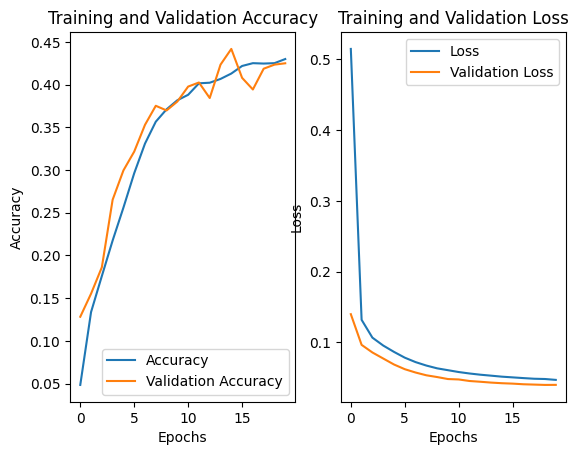

In [76]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history_rnn.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [77]:
# Đánh giá mô hình RNN
rnn_score = model_rnn.evaluate(X_test, y_test, batch_size=64)
print(f'RNN Test loss: {rnn_score[0]}')
print(f'RNN Test accuracy: {rnn_score[1]}')

62/62 [==============================] - 4s 60ms/step - loss: 0.0939 - accuracy: 0.2393
RNN Test loss: 0.0938759446144104
RNN Test accuracy: 0.2392575591802597


In [78]:
# Dự đoán với mô hình RNN
rnn_predictions = model_rnn.predict(X_test)
# Chuyển đổi dự đoán thành nhãn
rnn_pred_labels = mlb.inverse_transform((rnn_predictions > 0.5).astype(int))

123/123 [==============================] - 8s 59ms/step


In [79]:
# In ra một vài kết quả dự đoán
for i in range(5):
    print(f'Text: {X_test[i]}')
    print(f'Actual labels: {mlb.inverse_transform(np.expand_dims(y_test[i], axis=0))}')
    print(f'FFNN Predicted labels: {ffnn_pred_labels[i]}')
    print(f'RNN Predicted labels: {rnn_pred_labels[i]}')
    print('-----------------------------')

Text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 2731 1392  435  897  263 1207 3196    1  531  387    6    7
  112  346 6492 7551 5087  428  736 6894 4991 6445  114 6723 2218   16
 5327 1174  252 3157  111 5079   24  371 2080  244 2218   16  203 2162
   94  775 3975 2047 3605 6890  456  302 3533  901 2163   25   59  244
 2110   64  753 1868 5054 6139 5937 2412   64 6143 3978 2157  775 5491
 6846 7599]
Actual labels: [('Dệt may / Da giày / Thời trang', 'Quản lý chất lượng (QA/QC)', 'Tài chính / Đầu tư', 'Vận chuyển / Giao nhận / Kho vận', 'Điện / Điện tử / Điện lạnh')]
FFNN Predicted labels: ()
RNN Predicted labels: ()
-----------------------------
Text: [  366     7    49   139     7   889  3545   188  1247    49     0   668
   521  2071   276  3524  4213  3128  3342    34  4542  4545  1979    23
    27   668    26   708    68   180    33   584    23   371    69   364
  1164   